In [277]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from collections import Counter
import pycountry_convert as pc

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from tensorflow.keras.optimizers import Adam


import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

## Preprocessing 

In [278]:
df = pd.read_csv('preprocessed_imdb.csv')
df = df.dropna()

### Countries Feature

For dealing with countries feature we one hot them by their continent.  

In [279]:
def country_to_continent(country_name):
    if country_name == 'United States':
        country_name = "United States of America"

    if country_name == 'West Germany':
        country_name = "Germany"

    if country_name == 'Netherlands Antilles':
        country_name = "Venezuela"
    
    if country_name == 'Soviet Union':
        country_name = "Russia"
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    
    except LookupError:
        print(f"Country: {country_name} Not found")
        return "Not found"

In [280]:
df['Country_list'] = df['Country of Origin'].str.split('~')
df['Continents'] = df['Country_list'].apply(lambda countries: [country_to_continent(country) for country in countries])


all_continents = set(continent for sublist in df['Continents'] for continent in sublist)
for continent in all_continents:
    df[continent] = df['Continents'].apply(lambda x: int(continent in x))


df.drop(df[df['Not found'] == 1].index, inplace=True)
df = df.drop(columns=['Continents', 'Not found'])


df.describe()

Country: Serbia and Montenegro Not found
Country: Federal Republic of Yugoslavia Not found
Country: Yugoslavia Not found


,Release Year,Duration,Rating,Number of Votes,Meta Score,Budget,Gross (worldwide),profit,Europe,Asia,Oceania,Africa,South America,North America
count,4720.000000,4720.000000,4720.000000,4.720000e+03,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000
mean,2003.642797,111.307415,6.660763,1.731650e+05,57.971822,41.279362,128.291388,87.012026,0.342797,0.122669,0.047034,0.008686,0.005720,0.913983
std,13.421396,20.282864,0.930735,2.320341e+05,17.926348,47.459251,209.485580,178.956505,0.474694,0.328092,0.211734,0.092805,0.075424,0.280419
min,1950.000000,63.000000,1.500000,2.600000e+04,1.000000,0.001560,0.000126,-199.821857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1997.000000,97.000000,6.100000,5.000000e+04,45.000000,10.000000,19.059963,0.883066,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2006.000000,108.000000,6.700000,9.500000e+04,58.000000,25.000000,55.418696,28.148098,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2013.000000,121.000000,7.300000,1.960000e+05,71.000000,54.000000,147.969526,97.493462,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2024.000000,321.000000,9.300000,2.900000e+06,100.000000,356.000000,2923.706026,2686.706026,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Genere one hot encoding

In [281]:
df['Genre_list'] = df['Genre'].str.split('~')

all_genres = set(genre for sublist in df['Genre_list'] for genre in sublist)
print("total number of generes: ", len(all_genres))

for genre in all_genres:
    df[genre] = df['Genre_list'].apply(lambda x: int(genre in x))

df = df.drop(columns=['Genre_list'])

total number of generes:  22


In [282]:
genre_sums = df[list(all_genres)].sum()
genres_to_drop = genre_sums[genre_sums < 200].index
df.drop(columns=genres_to_drop, inplace=True)

In [283]:
genres_to_drop

Index(['War', 'Music', 'Documentary', 'Film-Noir', 'Western', 'Sport',
       'Musical', 'History'],
      dtype='object')

### companies

In [284]:
all_companies = df['Companies'].str.split('~').explode()
company_counts = Counter(all_companies)
top_companies = company_counts.most_common(25)
top_df = pd.DataFrame(top_companies, columns=['Company', 'Frequency'])
print(top_df)
print(top_df['Frequency'].sum() / df.shape[0])

                      Company  Frequency
0                Warner Bros.        372
1          Universal Pictures        362
2           Columbia Pictures        315
3          Paramount Pictures        309
4       Twentieth Century Fox        220
5        Walt Disney Pictures        176
6             New Line Cinema        171
7   Metro-Goldwyn-Mayer (MGM)        112
8            Relativity Media        110
9         Dreamworks Pictures        107
10    New Regency Productions        105
11        Touchstone Pictures        105
12            Lionsgate Films         87
13  Village Roadshow Pictures         84
14                    Miramax         72
15       Summit Entertainment         70
16       Amblin Entertainment         59
17                StudioCanal         56
18                Screen Gems         55
19          Fox 2000 Pictures         54
20             Focus Features         54
21    Legendary Entertainment         53
22           TriStar Pictures         53
23      Imagine 

In [285]:
df.describe()

,Release Year,Duration,Rating,Number of Votes,Meta Score,Budget,Gross (worldwide),profit,Europe,Asia,...,Drama,Adventure,Family,Comedy,Sci-Fi,Horror,Thriller,Biography,Mystery,Action
count,4720.000000,4720.000000,4720.000000,4.720000e+03,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,...,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000
mean,2003.642797,111.307415,6.660763,1.731650e+05,57.971822,41.279362,128.291388,87.012026,0.342797,0.122669,...,0.493432,0.236653,0.055932,0.360805,0.097034,0.127119,0.176059,0.073729,0.115678,0.306780
std,13.421396,20.282864,0.930735,2.320341e+05,17.926348,47.459251,209.485580,178.956505,0.474694,0.328092,...,0.500010,0.425072,0.229815,0.480285,0.296035,0.333141,0.380911,0.261357,0.319872,0.461206
min,1950.000000,63.000000,1.500000,2.600000e+04,1.000000,0.001560,0.000126,-199.821857,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1997.000000,97.000000,6.100000,5.000000e+04,45.000000,10.000000,19.059963,0.883066,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2006.000000,108.000000,6.700000,9.500000e+04,58.000000,25.000000,55.418696,28.148098,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2013.000000,121.000000,7.300000,1.960000e+05,71.000000,54.000000,147.969526,97.493462,1.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2024.000000,321.000000,9.300000,2.900000e+06,100.000000,356.000000,2923.706026,2686.706026,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [286]:
age_restriction_counts = df['Age Restriction'].value_counts()


valid_age_restrictions = age_restriction_counts[age_restriction_counts >= 200].index
df = df[df['Age Restriction'].isin(valid_age_restrictions)]


df = pd.concat([df, pd.get_dummies(df['Age Restriction'], prefix='Age_Restriction', dtype=int)], axis=1)
columns_to_drop = ['Age Restriction', 'Title']
df.drop(columns_to_drop, axis=1, inplace=True)

print(df.head())


   Release Year  Duration                    Genre  Rating  Number of Votes  \
0          1994       142                    Drama     9.3          2900000   
1          2008       152       Action~Crime~Drama     9.0          2900000   
2          2010       148  Action~Adventure~Sci-Fi     8.8          2500000   
3          1999       139                    Drama     8.8          2300000   
4          1994       142            Drama~Romance     8.8          2300000   

   Meta Score                 Language             Country of Origin  \
0          82                  English                 United States   
1          84         English~Mandarin  United States~United Kingdom   
2          74  English~Japanese~French  United States~United Kingdom   
3          67                  English         Germany~United States   
4          82                  English                 United States   

                                           Companies  Budget  ...  Comedy  \
0              

In [287]:
columns_to_drop = ['Country_list', 'Genre', 'Country of Origin', 'Companies','Language']
df.drop(columns_to_drop, axis=1, inplace=True)

## Feature Engineering

### Feature Scaling

In [288]:
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

exclude_columns = ['Europe', 'Asia', 'Oceania', 'Africa', 'South America', 'North America',
                   'Romance', 'Fantasy', 'Animation', 'Crime', 'Drama', 'Adventure',
                   'Family', 'Comedy', 'Sci-Fi', 'Horror', 'Thriller', 'Biography',
                   'Mystery', 'Action', 'Age_Restriction_PG', 'Age_Restriction_PG-13',
                   'Age_Restriction_R']

columns_to_scale = [col for col in df.columns if col not in exclude_columns]

min_max_scaler.fit(df)
df[df.columns] = min_max_scaler.transform(df)

standard_scaler.fit(df[columns_to_scale])
df[columns_to_scale] = standard_scaler.transform(df[columns_to_scale])

## Dimensionality Reduction

In [289]:
features = df.drop(columns=['profit', 'Rating'])
targets = df[['profit', 'Rating']]

### Use the PCA method to reduce the dimensions of numerical features to two dimensions

In [290]:
numerical_features = features.select_dtypes(include=[np.number])
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(numerical_features)



### How much of the initial data variance is transferred to the new space?

In [291]:
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
variance_ratio = pca.explained_variance_ratio_
transferred_variance = variance_ratio.sum()
print(f"Transferred variance to 2D space: {transferred_variance * 100:.2f}%")

Transferred variance to 2D space: 44.91%


### If we aim to retain 95% of the original variance, what is the minimum number of dimensions required in the new space?

In [292]:
pca_95 = PCA(0.95)
pca_95.fit(numerical_features)
n_components_95 = pca_95.n_components_
print(f"Number of components to retain 95% variance: {n_components_95}")

df.to_csv('preprocessed_original.csv', index=False)
reduced_df_with_targets = pd.concat([reduced_df, targets.reset_index(drop=True)], axis=1)
reduced_df_with_targets.to_csv('reduced_data.csv', index=False)

Number of components to retain 95% variance: 18


# Part 5: Model Training

## EDA for Enhancing Machine Learning Models

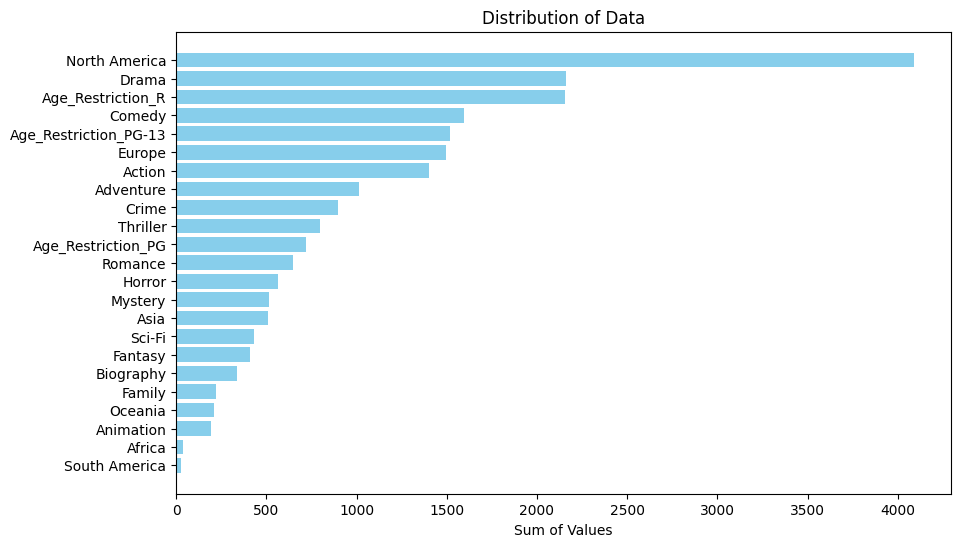

In [293]:
def calculate_column_sum(data, columns):
    column_sums = {}
    for column in columns:
        column_sums[column] = data[column].sum()
    return column_sums

specified_columns = ['North America', 'Africa', 'Asia', 'Europe', 'Oceania', 'South America', 
                     'Horror', 'Comedy', 'Fantasy', 'Drama', 'Family', 'Animation', 
                     'Biography', 'Adventure', 'Mystery', 'Action', 'Crime', 'Sci-Fi', 
                     'Thriller', 'Romance', 'Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R']

column_sums = calculate_column_sum(df, specified_columns)

sorted_column_sums = dict(sorted(column_sums.items(), key=lambda item: item[1]))

plt.figure(figsize=(10, 6))
plt.barh(list(sorted_column_sums.keys()), list(sorted_column_sums.values()), color='skyblue')
plt.xlabel('Sum of Values')
plt.title('Distribution of Data')
plt.show()

## Regression : 

In [294]:
data = pd.read_csv('preprocessed_original.csv')
data['Meta Score']

0       1.408398
1       1.521382
2       0.956461
3       0.561016
4       1.408398
          ...   
4393   -1.246731
4394   -1.133747
4395    0.730492
4396    0.786985
4397    0.052587
Name: Meta Score, Length: 4398, dtype: float64

Gross Worldwide - Mean Squared Error (Train): 0.020719032496788227
Gross Worldwide - Mean Squared Error (Test): 0.39761680294182056
Gross Worldwide - R^2 Score (Train): 0.9789440924036038
Gross Worldwide - R^2 Score (Test): 0.6259493262789735


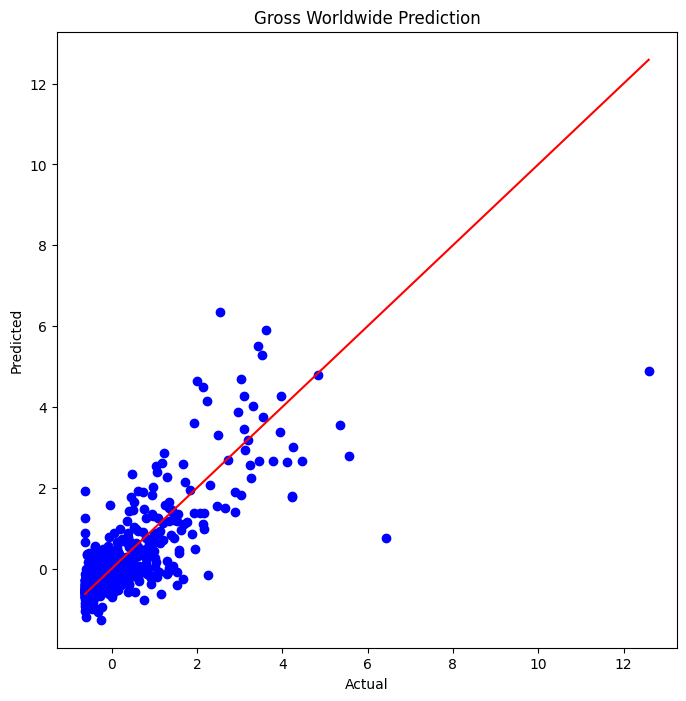

In [295]:
def load_and_prepare_data(file_path):
    data = pd.read_csv(file_path)
    data = data.select_dtypes(include=[float, int])
    return data

def split_and_standardize(data, target_column, drop_columns):
    X = data.drop(drop_columns, axis=1)
    y = data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888)
    return X_train, X_test, y_train, y_test

def train_model(X_train, y_train, hidden_layers=(100, 50), max_iter=500, random_state=888):
    model = MLPRegressor(hidden_layer_sizes=hidden_layers, activation='relu', solver='adam', max_iter=max_iter, random_state=random_state)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    return mse_train, mse_test, r2_train, r2_test

def print_results(task_name, mse_train, mse_test, r2_train, r2_test):
    print(f"{task_name} - Mean Squared Error (Train):", mse_train)
    print(f"{task_name} - Mean Squared Error (Test):", mse_test)
    print(f"{task_name} - R^2 Score (Train):", r2_train)
    print(f"{task_name} - R^2 Score (Test):", r2_test)

data = load_and_prepare_data('preprocessed_original.csv')

drop_columns_gross = ['profit', 'Budget', 'Gross (worldwide)']
X_train_gross, X_test_gross, y_train_gross, y_test_gross = split_and_standardize(data, 'Gross (worldwide)', drop_columns_gross)
model_gross = train_model(X_train_gross, y_train_gross)
mse_gross_train, mse_gross_test, r2_gross_train, r2_gross_test = evaluate_model(model_gross, X_train_gross, y_train_gross, X_test_gross, y_test_gross)
print_results("Gross Worldwide", mse_gross_train, mse_gross_test, r2_gross_train, r2_gross_test)


import matplotlib.pyplot as plt

def plot_predicted_vs_actual(y_test, y_pred, title):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') 
    plt.title(title)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()


plot_predicted_vs_actual(y_test_gross, model_gross.predict(X_test_gross), "Gross Worldwide Prediction")

Epoch 1/100, Train Loss: 0.6581, Validation Loss: 0.4813
Epoch 2/100, Train Loss: 0.5084, Validation Loss: 0.4434
Epoch 3/100, Train Loss: 0.4713, Validation Loss: 0.4029
Epoch 4/100, Train Loss: 0.4471, Validation Loss: 0.4146
Epoch 5/100, Train Loss: 0.4326, Validation Loss: 0.3925
Epoch 6/100, Train Loss: 0.4143, Validation Loss: 0.3928
Epoch 7/100, Train Loss: 0.4097, Validation Loss: 0.3857
Epoch 8/100, Train Loss: 0.3960, Validation Loss: 0.3656
Epoch 9/100, Train Loss: 0.3941, Validation Loss: 0.3644
Epoch 10/100, Train Loss: 0.3896, Validation Loss: 0.3588
Epoch 11/100, Train Loss: 0.3869, Validation Loss: 0.3582
Epoch 12/100, Train Loss: 0.3926, Validation Loss: 0.3606
Epoch 13/100, Train Loss: 0.3779, Validation Loss: 0.3584
Epoch 14/100, Train Loss: 0.3693, Validation Loss: 0.3669
Epoch 15/100, Train Loss: 0.3742, Validation Loss: 0.3633
Epoch 16/100, Train Loss: 0.3709, Validation Loss: 0.3659
Epoch 17/100, Train Loss: 0.3719, Validation Loss: 0.3578
Epoch 18/100, Train Los

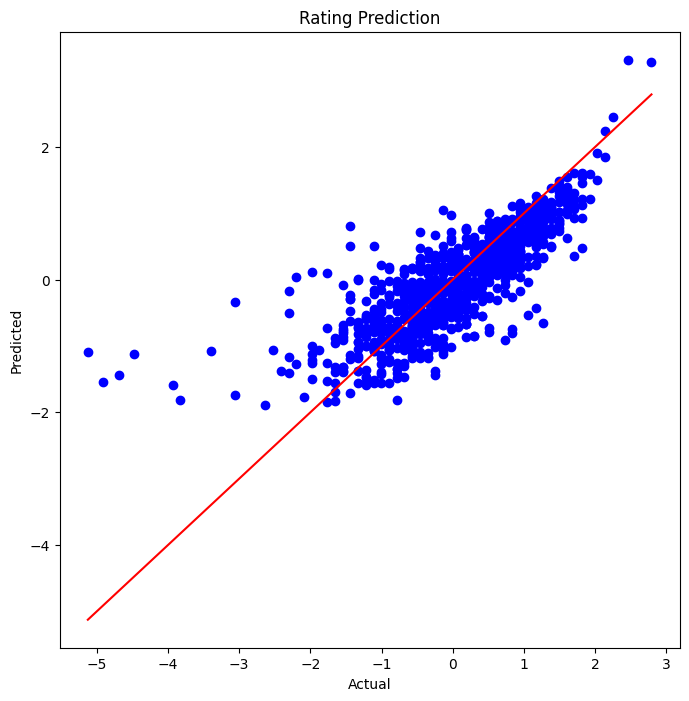

In [296]:
data = pd.read_csv('preprocessed_original.csv')
data = data.select_dtypes(include=[float, int])
rating_data = data.drop(['Meta Score'], axis=1)
X_rating = rating_data.drop('Rating', axis=1)
y_rating = rating_data['Rating']

X_train_rating, X_test_rating, y_train_rating, y_test_rating = train_test_split(X_rating, y_rating, test_size=0.2, random_state=888)

scaler = StandardScaler()
X_train_rating_scaled = scaler.fit_transform(X_train_rating)
X_test_rating_scaled = scaler.transform(X_test_rating)

X_train_tensor = torch.tensor(X_train_rating_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_rating.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_rating_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_rating.values, dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


class RatingNN(nn.Module):
    def __init__(self, input_size):
        super(RatingNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
model = RatingNN(X_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)


early_stopping_patience = 10
best_loss = float('inf')
epochs_no_improve = 0


num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    

    model.eval()
    with torch.no_grad():
        inputs, targets = X_test_tensor.to(device), y_test_tensor.to(device)
        outputs = model(inputs)
        val_loss = criterion(outputs, targets.unsqueeze(1)).item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    

    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        best_model = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print('Early stopping')
            break


model.load_state_dict(best_model)


model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor.to(device)).cpu().numpy()
    test_predictions = model(X_test_tensor.to(device)).cpu().numpy()
    
    
train_mse = mean_squared_error(y_train_tensor, train_predictions)
test_mse = mean_squared_error(y_test_tensor, test_predictions)
train_r2 = r2_score(y_train_tensor, train_predictions)
test_r2 = r2_score(y_test_tensor, test_predictions)

print(f'Train MSE: {train_mse:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Train R^2 Score: {train_r2:.4f}')
print(f'Test R^2 Score: {test_r2:.4f}')


plt.figure(figsize=(8, 8))
plt.scatter(y_test_tensor.cpu().numpy(), test_predictions, color='blue')
plt.plot([min(y_test_tensor.cpu().numpy()), max(y_test_tensor.cpu().numpy())], 
         [min(y_test_tensor.cpu().numpy()), max(y_test_tensor.cpu().numpy())], 
         color='red') 
plt.title("Rating Prediction")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()


Epoch 1/100, Train Loss: 0.6389, Validation Loss: 0.4437, Train R^2: 0.5631, Val R^2: 0.5456
Epoch 2/100, Train Loss: 0.4693, Validation Loss: 0.3930, Train R^2: 0.6149, Val R^2: 0.5975
Epoch 3/100, Train Loss: 0.4376, Validation Loss: 0.3941, Train R^2: 0.6188, Val R^2: 0.5963
Epoch 4/100, Train Loss: 0.4213, Validation Loss: 0.3760, Train R^2: 0.6363, Val R^2: 0.6149
Epoch 5/100, Train Loss: 0.4060, Validation Loss: 0.3771, Train R^2: 0.6395, Val R^2: 0.6137
Epoch 6/100, Train Loss: 0.3951, Validation Loss: 0.3699, Train R^2: 0.6512, Val R^2: 0.6211
Epoch 7/100, Train Loss: 0.3866, Validation Loss: 0.3644, Train R^2: 0.6557, Val R^2: 0.6267
Epoch 8/100, Train Loss: 0.3836, Validation Loss: 0.3553, Train R^2: 0.6613, Val R^2: 0.6361
Epoch 9/100, Train Loss: 0.3952, Validation Loss: 0.3696, Train R^2: 0.6558, Val R^2: 0.6214
Epoch 10/100, Train Loss: 0.3772, Validation Loss: 0.3543, Train R^2: 0.6629, Val R^2: 0.6371
Epoch 11/100, Train Loss: 0.3804, Validation Loss: 0.3685, Train R^2:

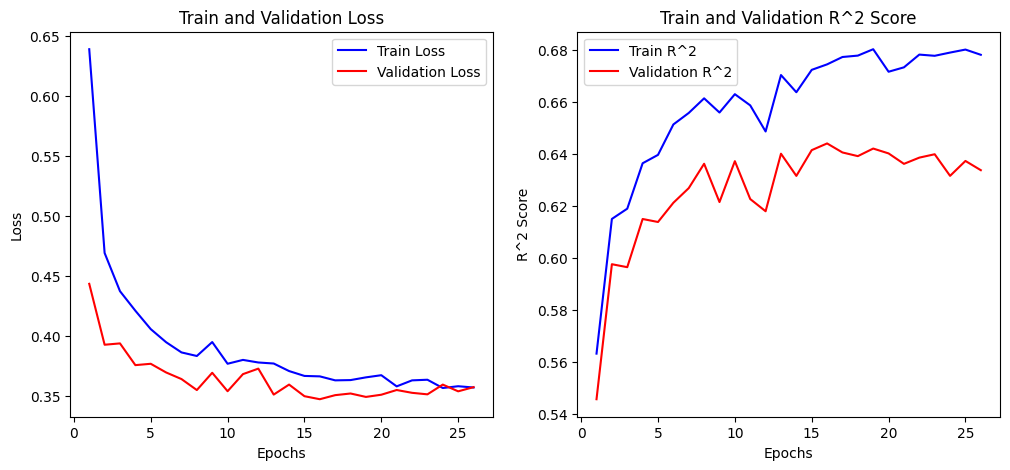

In [297]:
data = pd.read_csv('preprocessed_original.csv')


data = data.select_dtypes(include=[float, int])



rating_data = data.drop(['Meta Score'], axis=1)


X_rating = rating_data.drop('Rating', axis=1)
y_rating = rating_data['Rating']


X_train_rating, X_test_rating, y_train_rating, y_test_rating = train_test_split(X_rating, y_rating, test_size=0.2, random_state=888)

X_train_tensor = torch.tensor(X_train_rating.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_rating.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_rating.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_rating.values, dtype=torch.float32)



train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


class RatingNN(nn.Module):
    def __init__(self, input_size):
        super(RatingNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
model = RatingNN(X_train_tensor.shape[1]).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)


early_stopping_patience = 10
best_loss = float('inf')
epochs_no_improve = 0


train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []


num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    model.eval()
    with torch.no_grad():
        inputs, targets = X_test_tensor.to(device), y_test_tensor.to(device)
        outputs = model(inputs)
        val_loss = criterion(outputs, targets.unsqueeze(1)).item()
    train_predictions = model(X_train_tensor.to(device)).detach().cpu().numpy()
    train_r2 = r2_score(y_train_tensor, train_predictions)
    
    val_predictions = model(X_test_tensor.to(device)).detach().cpu().numpy()
    val_r2 = r2_score(y_test_tensor, val_predictions)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Train R^2: {train_r2:.4f}, Val R^2: {val_r2:.4f}')
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        best_model = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print('Early stopping')
            break


model.load_state_dict(best_model)


epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_r2_scores, 'b', label='Train R^2')
plt.plot(epochs, val_r2_scores, 'r', label='Validation R^2')
plt.title('Train and Validation R^2 Score')
plt.xlabel('Epochs')
plt.ylabel('R^2 Score')
plt.legend()

plt.show()


Linear Regression:
  Train MSE: 0.4817, Test MSE: 0.4940
  Train R^2: 0.5211, Test R^2: 0.4940
Ridge Regression:
  Train MSE: 0.4817, Test MSE: 0.4939
  Train R^2: 0.5211, Test R^2: 0.4941
Lasso Regression:
  Train MSE: 1.0059, Test MSE: 0.9766
  Train R^2: 0.0000, Test R^2: -0.0003
Gradient Boosting Regressor:
  Train MSE: 0.2762, Test MSE: 0.3594
  Train R^2: 0.7255, Test R^2: 0.6319


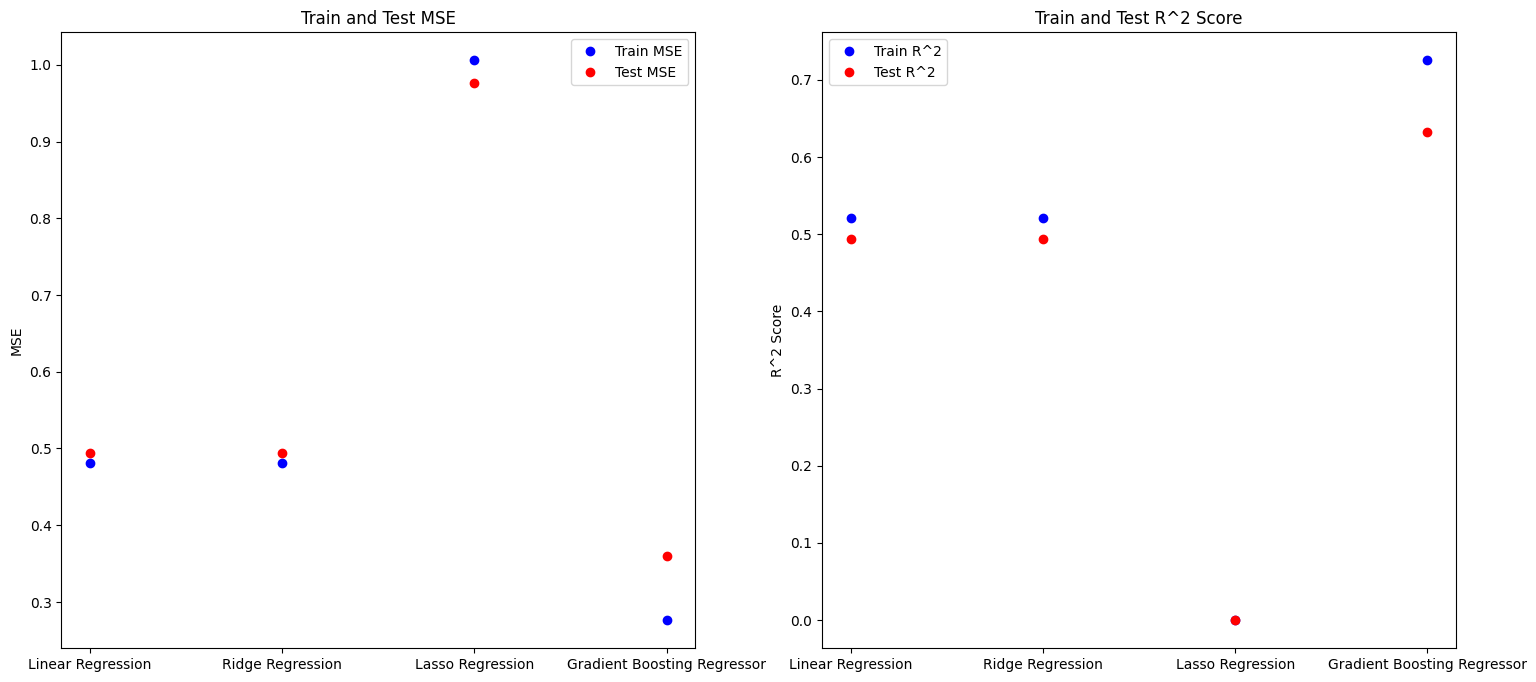

In [312]:
data = pd.read_csv('preprocessed_original.csv')
data = data.select_dtypes(include=[float, int])
rating_data = data.drop(['Meta Score'], axis=1)
X_rating = rating_data.drop('Rating', axis=1)
y_rating = rating_data['Rating']
X_train_rating, X_test_rating, y_train_rating, y_test_rating = train_test_split(X_rating, y_rating, test_size=0.2, random_state=888)


models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Gradient Boosting Regressor': GradientBoostingRegressor()
}


results = {}
for model_name, model in models.items():
    model.fit(X_train_rating, y_train_rating)
    y_train_pred = model.predict(X_train_rating)
    y_test_pred = model.predict(X_test_rating)
    
    train_mse = mean_squared_error(y_train_rating, y_train_pred)
    test_mse = mean_squared_error(y_test_rating, y_test_pred)
    train_r2 = r2_score(y_train_rating, y_train_pred)
    test_r2 = r2_score(y_test_rating, y_test_pred)
    
    results[model_name] = {
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Train R^2': train_r2,
        'Test R^2': test_r2
    }


for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Train MSE: {metrics['Train MSE']:.4f}, Test MSE: {metrics['Test MSE']:.4f}")
    print(f"  Train R^2: {metrics['Train R^2']:.4f}, Test R^2: {metrics['Test R^2']:.4f}")


plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
for model_name, metrics in results.items():
    plt.plot(model_name, metrics['Train MSE'], 'bo', label='Train MSE' if model_name == 'Linear Regression' else "")
    plt.plot(model_name, metrics['Test MSE'], 'ro', label='Test MSE' if model_name == 'Linear Regression' else "")
plt.title('Train and Test MSE')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
for model_name, metrics in results.items():
    plt.plot(model_name, metrics['Train R^2'], 'bo', label='Train R^2' if model_name == 'Linear Regression' else "")
    plt.plot(model_name, metrics['Test R^2'], 'ro', label='Test R^2' if model_name == 'Linear Regression' else "")
plt.title('Train and Test R^2 Score')
plt.ylabel('R^2 Score')
plt.legend()

plt.show()


Epoch 1/100, Train Loss: 0.6655, Validation Loss: 0.3791
Epoch 2/100, Train Loss: 0.4718, Validation Loss: 0.3103
Epoch 3/100, Train Loss: 0.3983, Validation Loss: 0.2911
Epoch 4/100, Train Loss: 0.4119, Validation Loss: 0.2891
Epoch 5/100, Train Loss: 0.3620, Validation Loss: 0.2809
Epoch 6/100, Train Loss: 0.3699, Validation Loss: 0.2859
Epoch 7/100, Train Loss: 0.3617, Validation Loss: 0.2670
Epoch 8/100, Train Loss: 0.3635, Validation Loss: 0.2784
Epoch 9/100, Train Loss: 0.3449, Validation Loss: 0.2966
Epoch 10/100, Train Loss: 0.3584, Validation Loss: 0.2678
Epoch 11/100, Train Loss: 0.3406, Validation Loss: 0.2733
Epoch 12/100, Train Loss: 0.3406, Validation Loss: 0.2662
Epoch 13/100, Train Loss: 0.3204, Validation Loss: 0.2617
Epoch 14/100, Train Loss: 0.3331, Validation Loss: 0.2569
Epoch 15/100, Train Loss: 0.3200, Validation Loss: 0.2554
Epoch 16/100, Train Loss: 0.3520, Validation Loss: 0.2806
Epoch 17/100, Train Loss: 0.3373, Validation Loss: 0.2849
Epoch 18/100, Train Los

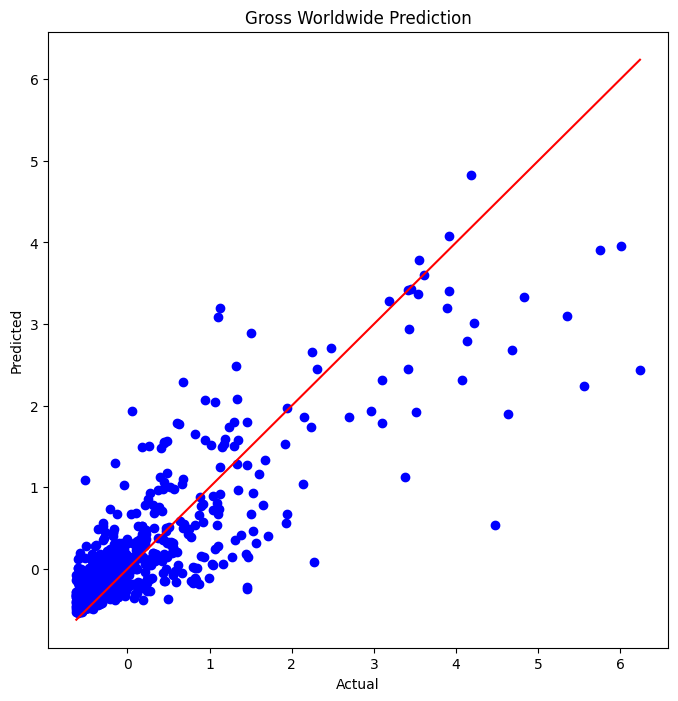

In [299]:
gross_data = data.drop(['Budget', 'profit'], axis=1)
X_gross = gross_data.drop('Gross (worldwide)', axis=1)
y_gross = gross_data['Gross (worldwide)']


X_train_gross, X_test_gross, y_train_gross, y_test_gross = train_test_split(X_gross, y_gross, test_size=0.2)

X_train_tensor_gross = torch.tensor(X_train_gross.values, dtype=torch.float32)
y_train_tensor_gross = torch.tensor(y_train_gross.values, dtype=torch.float32)
X_test_tensor_gross = torch.tensor(X_test_gross.values, dtype=torch.float32)
y_test_tensor_gross = torch.tensor(y_test_gross.values, dtype=torch.float32)


train_dataset_gross = TensorDataset(X_train_tensor_gross, y_train_tensor_gross)
train_loader_gross = DataLoader(train_dataset_gross, batch_size=32, shuffle=True)


class GrossNN(nn.Module):
    def __init__(self, input_size):
        super(GrossNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model_gross = GrossNN(X_train_tensor_gross.shape[1]).to(device)


criterion_gross = nn.MSELoss()
optimizer_gross = optim.Adam(model_gross.parameters(), lr=0.001, weight_decay=0.01)


best_loss_gross = float('inf')
epochs_no_improve_gross = 0


num_epochs_gross = 100
for epoch in range(num_epochs_gross):
    model_gross.train()
    train_loss_gross = 0.0
    
    for inputs, targets in train_loader_gross:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer_gross.zero_grad()
        outputs = model_gross(inputs)
        loss = criterion_gross(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer_gross.step()
        
        train_loss_gross += loss.item() * inputs.size(0)
    
    train_loss_gross /= len(train_loader_gross.dataset)
    model_gross.eval()
    with torch.no_grad():
        inputs, targets = X_test_tensor_gross.to(device), y_test_tensor_gross.to(device)
        outputs = model_gross(inputs)
        val_loss_gross = criterion_gross(outputs, targets.unsqueeze(1)).item()
    
    print(f'Epoch {epoch+1}/{num_epochs_gross}, Train Loss: {train_loss_gross:.4f}, Validation Loss: {val_loss_gross:.4f}')
    if val_loss_gross < best_loss_gross:
        best_loss_gross = val_loss_gross
        epochs_no_improve_gross = 0
        best_model_gross = model_gross.state_dict()
    else:
        epochs_no_improve_gross += 1
        if epochs_no_improve_gross >= early_stopping_patience:
            print('Early stopping')
            break


model_gross.load_state_dict(best_model_gross)


model_gross.eval()
with torch.no_grad():
    train_predictions_gross = model_gross(X_train_tensor_gross.to(device)).cpu().numpy()
    test_predictions_gross = model_gross(X_test_tensor_gross.to(device)).cpu().numpy()
    
train_mse_gross = mean_squared_error(y_train_tensor_gross, train_predictions_gross)
test_mse_gross = mean_squared_error(y_test_tensor_gross, test_predictions_gross)

train_r2_gross = r2_score(y_train_tensor_gross, train_predictions_gross)
test_r2_gross = r2_score(y_test_tensor_gross, test_predictions_gross)

print(f'Train MSE for Gross: {train_mse_gross:.4f}')
print(f'Test MSE for Gross: {test_mse_gross:.4f}')
print(f'Train R^2 Score for Gross: {train_r2_gross:.4f}')
print(f'Test R^2 Score for Gross: {test_r2_gross:.4f}')

plt.figure(figsize=(8, 8))
plt.scatter(y_test_tensor_gross.cpu().numpy(), test_predictions_gross, color='blue')
plt.plot([min(y_test_tensor_gross.cpu().numpy()), max(y_test_tensor_gross.cpu().numpy())], 
         [min(y_test_tensor_gross.cpu().numpy()), max(y_test_tensor_gross.cpu().numpy())], 
         color='red') 
plt.title("Gross Worldwide Prediction")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()



# Classification :

In [300]:
data = pd.read_csv('preprocessed_original.csv')
data = data.select_dtypes(include=[float, int])
data.columns

Index(['Release Year', 'Duration', 'Rating', 'Number of Votes', 'Meta Score',
       'Budget', 'Gross (worldwide)', 'profit', 'Europe', 'Asia', 'Oceania',
       'Africa', 'South America', 'North America', 'Romance', 'Fantasy',
       'Animation', 'Crime', 'Drama', 'Adventure', 'Family', 'Comedy',
       'Sci-Fi', 'Horror', 'Thriller', 'Biography', 'Mystery', 'Action',
       'Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R'],
      dtype='object')

In [301]:
X = data.drop(['Africa', 'North America', 'Europe', 'Oceania', 'Asia', 'South America'], axis=1)
y = data[['Africa', 'North America', 'Europe', 'Oceania', 'Asia', 'South America']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888)


model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')
])


model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)


y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = y_test.values.argmax(axis=-1)


print(classification_report(y_test_classes, y_pred_classes, zero_division=0))

Epoch 1/20
55/55 [==============================] - 1s 3ms/step - loss: 1.9270 - accuracy: 0.8829
Epoch 2/20
55/55 [==============================] - 0s 2ms/step - loss: 4.4006 - accuracy: 0.8380
Epoch 3/20
55/55 [==============================] - 0s 1ms/step - loss: 17.4460 - accuracy: 0.7726
Epoch 4/20
55/55 [==============================] - 0s 1ms/step - loss: 49.0023 - accuracy: 0.7743
Epoch 5/20
55/55 [==============================] - 0s 1ms/step - loss: 105.5126 - accuracy: 0.7709
Epoch 6/20
55/55 [==============================] - 0s 1ms/step - loss: 175.8644 - accuracy: 0.7581
Epoch 7/20
55/55 [==============================] - 0s 1ms/step - loss: 272.9076 - accuracy: 0.7635
Epoch 8/20
55/55 [==============================] - 0s 3ms/step - loss: 388.7157 - accuracy: 0.7732
Epoch 9/20
55/55 [==============================] - 0s 2ms/step - loss: 524.9672 - accuracy: 0.7538
Epoch 10/20
55/55 [==============================] - 0s 1ms/step - loss: 693.1987 - accuracy: 0.7618
Epoch

              precision    recall  f1-score   support

           0       0.82      0.62      0.71       155
           1       0.63      0.55      0.59       302
           2       0.71      0.80      0.75       423

   micro avg       0.70      0.68      0.69       880
   macro avg       0.72      0.66      0.68       880
weighted avg       0.70      0.68      0.69       880
 samples avg       0.66      0.68      0.67       880



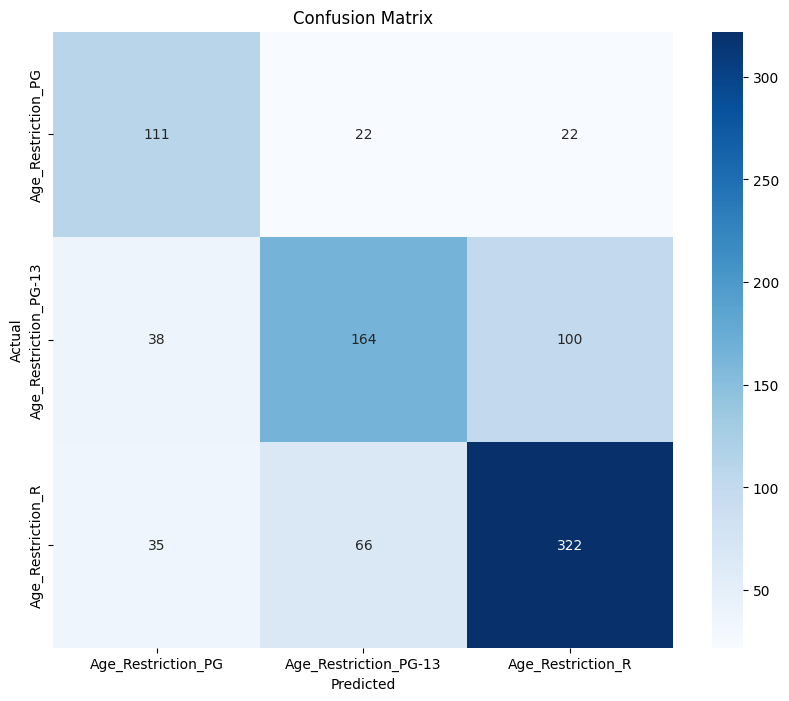

In [313]:
data = pd.read_csv('preprocessed_original.csv')

features = data.drop([ 'Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R'], axis=1)
target = data[[ 'Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R']]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=888)

clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=3000,random_state=888)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target.columns, yticklabels=target.columns)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Random forest : 

              precision    recall  f1-score   support

           0       0.91      0.50      0.64       155
           1       0.69      0.54      0.61       302
           2       0.75      0.77      0.76       423

   micro avg       0.75      0.64      0.69       880
   macro avg       0.78      0.60      0.67       880
weighted avg       0.76      0.64      0.69       880
 samples avg       0.64      0.64      0.64       880



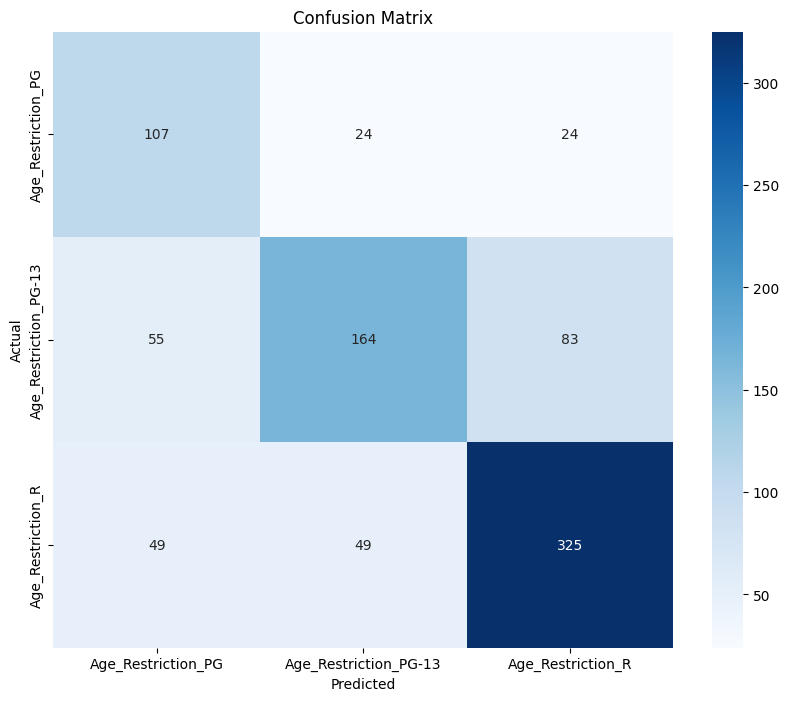

In [303]:
data = pd.read_csv('preprocessed_original.csv')


features = data.drop(['Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R'], axis=1)
target = data[['Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R']]


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=888)


clf = RandomForestClassifier(n_estimators=100, random_state=888)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target.columns, yticklabels=target.columns)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Best parameters found: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'max_iter': 2000, 'solver': 'sgd'}
              precision    recall  f1-score   support

           0       0.86      0.61      0.72       155
           1       0.65      0.66      0.66       302
           2       0.77      0.81      0.79       423

   micro avg       0.74      0.72      0.73       880
   macro avg       0.76      0.69      0.72       880
weighted avg       0.75      0.72      0.73       880
 samples avg       0.71      0.72      0.71       880



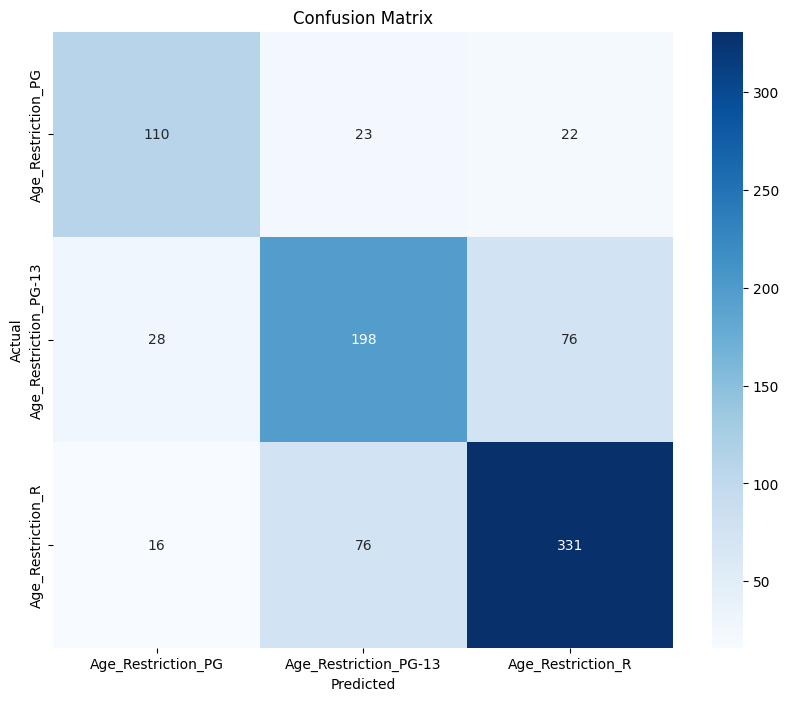

In [314]:
data = pd.read_csv('preprocessed_original.csv')

features = data.drop(['Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R'], axis=1)
target = data[['Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R']]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=888)


mlp = MLPClassifier(random_state=888)


param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'max_iter': [2000, 3000]
}


grid_search = GridSearchCV(mlp, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)


print("Best parameters found:", grid_search.best_params_)

y_pred = grid_search.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target.columns, yticklabels=target.columns)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Best parameters found: {'activation': 'relu', 'hidden_layer_sizes': (100, 50), 'max_iter': 1000, 'solver': 'adam'}
              precision    recall  f1-score   support

           0       0.75      0.63      0.68       155
           1       0.59      0.62      0.60       302
           2       0.73      0.75      0.74       423

   micro avg       0.68      0.68      0.68       880
   macro avg       0.69      0.66      0.67       880
weighted avg       0.68      0.68      0.68       880
 samples avg       0.67      0.68      0.67       880



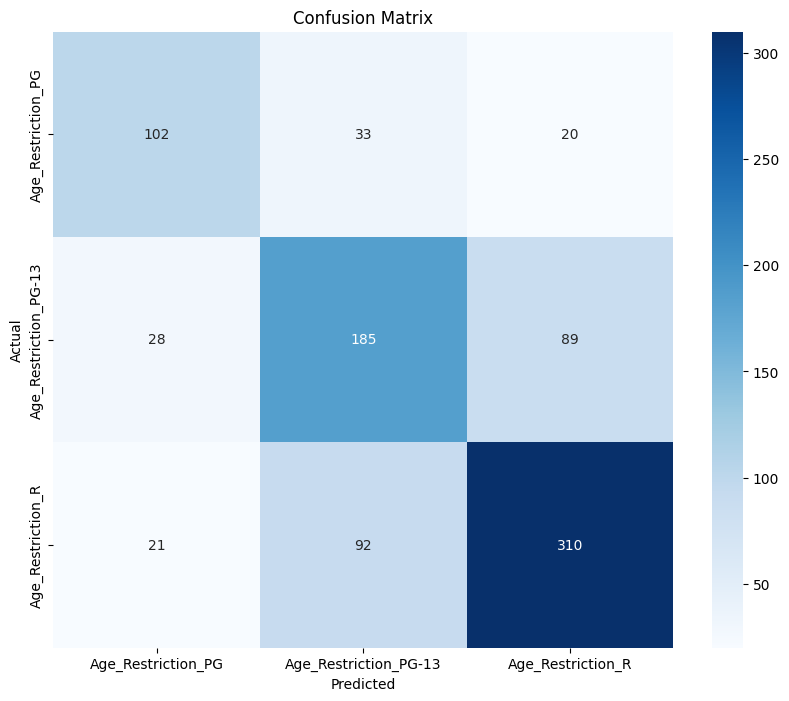

In [305]:
data = pd.read_csv('preprocessed_original.csv')


features = data.drop(['Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R'], axis=1)
target = data[['Age_Restriction_PG', 'Age_Restriction_PG-13', 'Age_Restriction_R']]


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=888)


y_train_np = y_train.to_numpy()


smote = SMOTE(random_state=888)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_np)


mlp = MLPClassifier(random_state=888)


param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'max_iter': [500, 1000]
}


grid_search = GridSearchCV(mlp, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)


print("Best parameters found:", grid_search.best_params_)


y_pred = grid_search.best_estimator_.predict(X_test)


print(classification_report(y_test, y_pred, zero_division=0))


cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target.columns, yticklabels=target.columns)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


               precision    recall  f1-score   support

Above Average       0.81      0.80      0.80       559
      Average       0.60      0.56      0.58       220
Below Average       0.15      0.46      0.23        13
         High       0.63      0.63      0.63        83
          Low       0.33      0.40      0.36         5

     accuracy                           0.71       880
    macro avg       0.51      0.57      0.52       880
 weighted avg       0.73      0.71      0.72       880



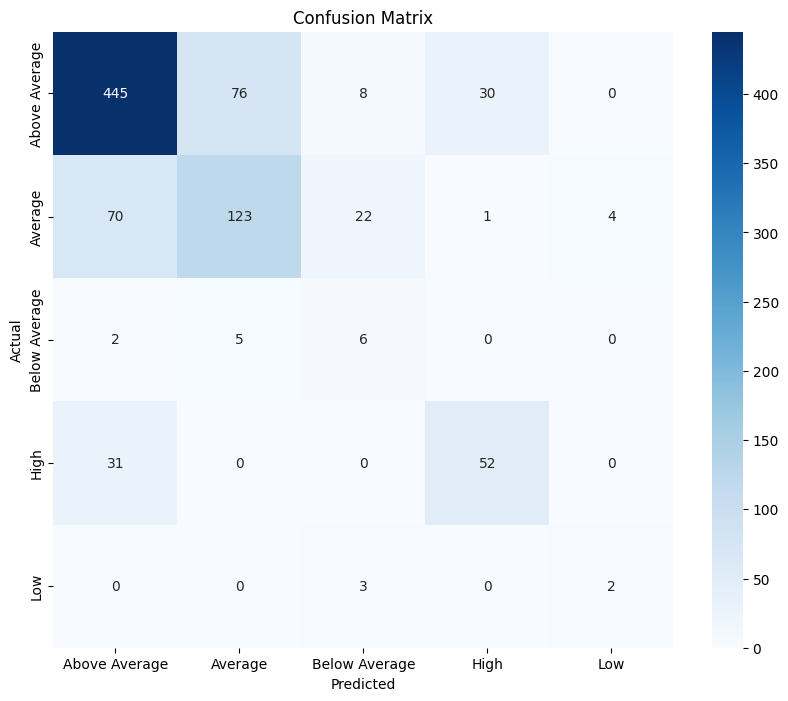

In [315]:
data = pd.read_csv('preprocessed_original.csv')

data['Rating_Class'] = pd.cut(data['Rating'], bins=5, labels=['Low', 'Below Average', 'Average', 'Above Average', 'High'])
features = data.drop(['Rating', 'Rating_Class'], axis=1)
target = data['Rating_Class']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=888)


adasyn = ADASYN(random_state=888)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

mlp = MLPClassifier(hidden_layer_sizes=(50,), activation='tanh', solver='adam', max_iter=3000, random_state=888)
mlp.fit(X_train_balanced, y_train_balanced)
y_pred = mlp.predict(X_test)


print(classification_report(y_test, y_pred, zero_division=0))
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [1]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from copy import deepcopy

class Evaluator:
    def __init__(self, models: dict, x_test, y_test, x_train, y_train):
        self.models = models
        self.x_test = x_test
        self.y_test = y_test
        self.x_train = x_train
        self.y_train = y_train
        self.predict = dict()
    
    def evaluate_models(self):
        predict = {i: self.models[i].predict(self.x_test) for i in self.models.keys()}
        result = dict()
        for model in self.models.keys():
            result[model] = {'Accuracy': accuracy_score(self.y_test, predict[model]),
                             'F1': f1_score(self.y_test, predict[model]),
                             'Precision': precision_score(self.y_test, predict[model]),
                             'Recall': recall_score(self.y_test, predict[model])}
        return pd.DataFrame(result).transpose()
    
    def calculate_confusion_matrix(self):
        output = dict()
        for model in self.models.keys():
            result = confusion_matrix(self.y_test, self.predict[model])
            
            sns.heatmap(result, annot=True, cmap='coolwarm', xticklabels=self.models[model].classes_, yticklabels=self.models[model].classes_)
            plt.title(f"Confusion Matrix for Model {model}")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()
            
            output[model] = result
        return output
    
    def modify_model_list(self, model):
        for attr in model.keys():
            self.models[attr] = model[attr]
            
    def clear_previous_result(self):
        self.models.clear()
        self.predict.clear()
    
    def train_new_models(self, models):
        for name, model in models.items():
            self.modify_model_list({f'{name}':deepcopy(model).fit(self.x_train, self.y_train)})
        

IndentationError: expected an indented block after 'for' statement on line 28 (4269234479.py, line 30)

In [ ]:
from sklearn.svm import SVC
evaluator_SVM = Evaluator({}, X_test, y_test, X_train, y_train)
for kernel in {'linear', 'poly', 'sigmoid', 'rbf'}:
  evaluator_SVM.fit_models({f'SVM {kernel}': SVC(kernel=kernel)})
evaluator_SVM.calculate_evaluators()

     

In [ ]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

dt = DecisionTreeClassifier(max_depth=20)
rf = RandomForestClassifier(n_estimators=300, max_depth=20)
xgb = XGBClassifier(n_estimators=300, learning_rate=0.1)

evaluator_random_forest = Evaluator({}, X_test, y_test, X_train, y_train)
for kernel in {'linear', 'poly', 'sigmoid', 'rbf'}:
  evaluator_random_forest.fit_models({f'SVM {kernel}': RandomForestClassifier(max_depth=20, kernel=kernel)})
evaluator_random_forest.calculate_evaluators()

evaluator_decision_tree = Evaluator({}, X_test, y_test, X_train, y_train)
for kernel in {'linear', 'poly', 'sigmoid', 'rbf'}:
  evaluator_decision_tree.fit_models({f'SVM {kernel}': DecisionTreeClassifier(max_depth=20, kernel=kernel)})
evaluator_decision_tree.calculate_evaluators()

evaluator_xgboost = Evaluator({}, X_test, y_test, X_train, y_train)
for kernel in {'linear', 'poly', 'sigmoid', 'rbf'}:
  evaluator_xgboost.fit_models({f'SVM {kernel}': XGBClassifier(max_depth=20, kernel=kernel)})
evaluator_xgboost.calculate_evaluators()
  
models = {'Decision Tree': dt, 'Random Forest': rf, 'XGBoost': xgb}
evaluator = Evaluator(models, X_test, y_test, X_train, y_train)